In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [ ]:
import numpy as np
import pandas as pd
import cv2  # Ensure OpenCV is imported for image conversion

def compute_entropy_curve(image):
    # Convert image to 8-bit if it’s in float format
    if image.dtype != np.uint8:
        print("Converting image to 8-bit (0-255) range for histogram calculation.")
        image = (image * 255).astype(np.uint8)

    # Calculate the histogram of the image
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    total_pixels = hist.sum()

    # Print histogram for debugging
    #print("Histogram:")
    #print(hist)

    # Calculate the probability for each intensity level
    prob = hist / total_pixels
    prob[prob == 0] = np.nan  # Avoid log(0) by setting zero probabilities to NaN

    # Calculate entropy for each intensity level
    entropy_values = -prob * np.log2(prob)
    entropy_values = np.nan_to_num(entropy_values, nan=0.0)  # Replace NaNs with zero in entropy result

    # Check if entropy_values is flat or all zeros
    if np.all(entropy_values == 0):
        print("Warning: Entropy curve is flat or all zeros.")

        # Create and print a detailed table
        equation = []
        for i in range(256):
            if np.isnan(prob[i]):
                equation.append("0")
            else:
                equation.append(f"-{prob[i]:.4f} * log2({prob[i]:.4f})")

        # Create a DataFrame for a clean table format
        table = pd.DataFrame({
            "Intensity Level": np.arange(256),
            "Original Histogram": hist,
            "Equation": equation,
            "Entropy Value": entropy_values
        })

        print(table.to_string(index=False))

    return entropy_values


In [227]:
import numpy as np

def clip_and_slice_entropy_curve(E, image, quantiles=[0.25, 0.5, 0.75]):
    # Step 1: Calculate the quantiles and clipping limit as per the paper
    Q0, Q1, Q2, Q3 = np.quantile(E[E > 0], [0.0, quantiles[0], quantiles[1], quantiles[2]])
    Cclip = (Q0 + Q1 + Q2 + Q3) / 4
    clipped_entropy_curve = np.minimum(E, Cclip)

    # Step 2: Compute the histogram and weighted mean intensity
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    intensity_levels = np.arange(256)
    mean_intensity = np.sum(intensity_levels * E) / np.sum(E)

    # Step 3: Compute the weighted standard deviation as per the paper
    weighted_variance = np.sum(((intensity_levels - mean_intensity) ** 2) * hist) / np.sum(hist)
    std_intensity = np.sqrt(weighted_variance)

    # Step 4: Find the intensity levels with minimum and maximum entropy in the clipped entropy curve
    non_zero_indices = np.nonzero(clipped_entropy_curve)[0]  # Indices where entropy > 0
    min_entropy_index = non_zero_indices[np.argmin(clipped_entropy_curve[non_zero_indices])]
    max_entropy_index = non_zero_indices[np.argmax(clipped_entropy_curve[non_zero_indices])]

    # Convert the indices to the actual intensity level values
    L_m = min_entropy_index
    L_M = max_entropy_index

    if L_m > L_M:
        L_m, L_M = L_M, L_m

    #print(f"| Paper has | L_m = {L_m} | L_M ={L_M} | {std_intensity} | {L_m+std_intensity} | {L_M+std_intensity}")
    #print(f"| Paper has | L_m = {L_m} | L_M = {L_M} | {std_intensity} | {L_m-std_intensity} | {L_M+std_intensity}")
    # Step 5: Calculate lower and upper limits based on SD
    L_l = min(255,max(0, int(L_m + std_intensity)))
    L_H = min(255,max(0, int(L_M + std_intensity)))

    return clipped_entropy_curve, L_l, L_H

def equalize_entropy_segments(image, clipped_entropy_curve, lower_threshold, upper_threshold):
    # Step 1: Divide the entropy curve into three segments
    segments = [
        (0, max(0, lower_threshold)),
        (max(0, lower_threshold + 1), min(255, upper_threshold)),
        (min(255, upper_threshold + 1), 255)
    ]
    #print(f"Thresholds: {lower_threshold} - {upper_threshold}")

    # Initialize an empty array to store the enhanced image
    equalized_image = np.zeros_like(image, dtype=np.float32)

    # Step 2: Calculate total entropy of the clipped entropy curve for normalization
    total_entropy = np.sum(clipped_entropy_curve)

    # Step 3: Perform equalization for each segment
    for start, end in segments:
        # Mask to select pixels in the current segment
        mask = (image >= start) & (image <= end)
        if not np.any(mask):
            #print(start,end)
            print("No mask found..")
            continue

        # Calculate normalized entropy values (NEV) for the current segment
        segment_entropy = clipped_entropy_curve[start:end + 1]
        normalized_entropy = segment_entropy / total_entropy

        # Calculate the accumulated entropy value `e_k` for the current segment
        e_k = np.sum(normalized_entropy)

        # Calculate the cumulative entropy values (CEV_k) for each intensity level in the segment
        cumulative_entropy_values = np.cumsum(normalized_entropy) / e_k

        # Apply the transformation function for each segment using the cumulative entropy
        transformed_values = start + (end - start) * cumulative_entropy_values

        # Map the transformed values back to the segment in the image
        segment_pixels = image[mask]
        equalized_image[mask] = np.interp(segment_pixels, np.arange(start, end + 1), transformed_values)

    # Clip values to the range 0-255 and convert to uint8 for image representation
    return np.clip(equalized_image, 0, 255).astype(np.uint8)

In [228]:
import numpy as np
import cv2

def entropy_based_contrast_enhancement(image):
    # Convert to grayscale if the image has multiple channels (e.g., is color)
    if len(image.shape) == 3 and image.shape[2] == 3:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale_image = image  # Image is already grayscale

    # Convert image to 8-bit if it’s in float format or not in the uint8 range
    if grayscale_image.dtype != np.uint8:
        #print("Converting image to 8-bit (0-255) range for processing.")
        grayscale_image = (grayscale_image * 255).astype(np.uint8)

    # Step 1: Compute entropy curve
    entropy_curve = compute_entropy_curve(grayscale_image)

    # Step 2: Clip and slice the entropy curve
    clipped_entropy_curve, lower_thresh, upper_thresh = clip_and_slice_entropy_curve(entropy_curve, grayscale_image)

    # Step 3: Equalize the image using the entropy segments
    enhanced_image = equalize_entropy_segments(grayscale_image, clipped_entropy_curve, lower_thresh, upper_thresh)

    return enhanced_image

In [229]:
from skimage import data, img_as_float
image = data.moon()
image.shape

(512, 512)

(-0.5, 511.5, 511.5, -0.5)

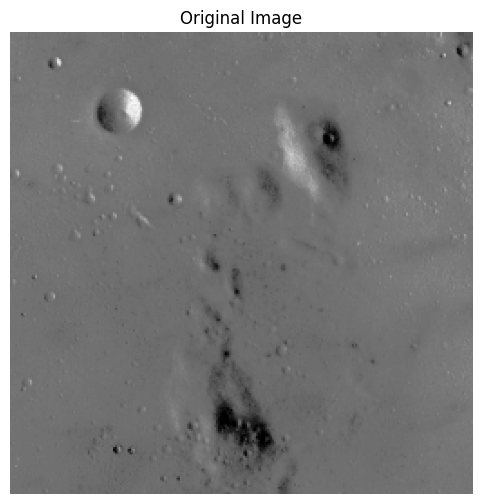

In [230]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.title('Original Image')
plt.imshow(image, cmap="gray")
plt.axis('off')

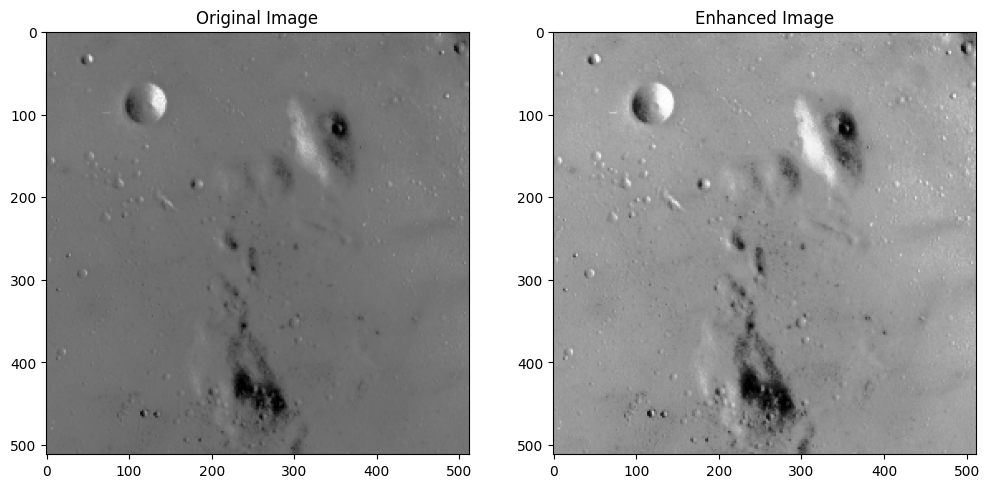

In [231]:
# Apply the entropy-based contrast enhancement
enhanced_image = entropy_based_contrast_enhancement(image)

# Show the original and enhanced images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(enhanced_image, cmap='gray')
plt.show()


### Evaluation
We use Berkley Segmentation Dataset (BSDS)

#### Dataset Download

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/berkeley-segmentation-dataset-500-bsds500")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500/versions/1


In [ ]:
!mv /root/.cache/kagglehub/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500/versions/1/ .

In [ ]:
!mv 1 BSDS300

In [ ]:
!ls BSDS300/images/test
!pwd

100007.jpg  118031.jpg	159002.jpg  196040.jpg	230098.jpg  289011.jpg	376086.jpg  69022.jpg
100039.jpg  118072.jpg	159022.jpg  196062.jpg	23050.jpg   290035.jpg	384022.jpg  70011.jpg
100099.jpg  120003.jpg	160006.jpg  196088.jpg	232076.jpg  29030.jpg	384089.jpg  70090.jpg
10081.jpg   120093.jpg	16004.jpg   198087.jpg	235098.jpg  296028.jpg	385022.jpg  71076.jpg
101027.jpg  123057.jpg	160067.jpg  20069.jpg	238025.jpg  296058.jpg	388006.jpg  71099.jpg
101084.jpg  128035.jpg	16068.jpg   201080.jpg	243095.jpg  302022.jpg	388018.jpg  77062.jpg
102062.jpg  130014.jpg	161045.jpg  2018.jpg	246009.jpg  306051.jpg	388067.jpg  78098.jpg
103006.jpg  130066.jpg	163004.jpg  202000.jpg	247003.jpg  306052.jpg	393035.jpg  79073.jpg
103029.jpg  134049.jpg	163096.jpg  206062.jpg	247012.jpg  3063.jpg	41006.jpg   80085.jpg
103078.jpg  134067.jpg	164046.jpg  206097.jpg	249021.jpg  309040.jpg	41029.jpg   80090.jpg
104010.jpg  140006.jpg	168084.jpg  207038.jpg	250047.jpg  317043.jpg	41085.jpg   8068.jpg
104055

In [ ]:
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.io import imread_collection
import os

# Define the path where BSDS300 images are located
dataset_dir = "/content/BSDS300/images/test"  # Update with the correct path

def load_bsds_images():
    # Ensure the dataset directory exists
    if not os.path.exists(dataset_dir):
        print("Dataset directory not found. Please download BSDS300 and place it in the specified path.")
        return []

    # Load all JPEG images in the dataset directory
    image_files = f"{dataset_dir}/*.jpg"
    images = imread_collection(image_files)  # Loads all .jpg files in the directory
    return [rgb2gray(img_as_float(img)) for img in images]  # Convert to grayscale

In [ ]:
images = load_bsds_images()

#### Routined Evaluation

In [ ]:
# Import necessary packages
from skimage import exposure

# Histogram Equalization using OpenCV
def histogram_equalization(image):
    # Convert to uint8 and apply histogram equalization
    image_8bit = (image * 255).astype(np.uint8)
    equalized_image = cv2.equalizeHist(image_8bit)
    return equalized_image

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error

# Calculate RMSE
def rmse(original, enhanced):
    return np.sqrt(mean_squared_error(original, enhanced))

# Calculate PSNR (already provided by skimage)
def calculate_metrics(original, enhanced):
    psnr_value = psnr(original, enhanced, data_range=255)
    rmse_value = rmse(original, enhanced)
    return psnr_value, rmse_value


In [232]:
# Load BSDS dataset

# Initialize lists to store metrics
psnr_hist_eq = []
rmse_hist_eq = []
psnr_custom = []
rmse_custom = []

for index,image in enumerate(images):
    # Original image in 8-bit format
    original_8bit = (image * 255).astype(np.uint8)

    # Apply Histogram Equalization
    hist_eq_image = histogram_equalization(image)
    psnr_value, rmse_value = calculate_metrics(original_8bit, hist_eq_image)
    psnr_hist_eq.append(psnr_value)
    rmse_hist_eq.append(rmse_value)

    # Apply Custom Entropy-Based Enhancement
    custom_enhanced_image = entropy_based_contrast_enhancement(image)
    psnr_value, rmse_value = calculate_metrics(original_8bit, custom_enhanced_image)
    psnr_custom.append(psnr_value)
    rmse_custom.append(rmse_value)

# Display the average PSNR and RMSE for each method
print(f"Histogram Equalization - Average PSNR: {np.mean(psnr_hist_eq):.2f}, Average RMSE: {np.mean(rmse_hist_eq):.2f}")
print(f"Custom Enhancement - Average PSNR: {np.mean(psnr_custom):.2f}, Average RMSE: {np.mean(rmse_custom):.2f}")


No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
No mask found..
Histogram Equalization - Average PSNR: 16.77, Average RMSE: 41.50
Custom Enhancement - Average PSNR: 25.53, Average RMSE: 16.43


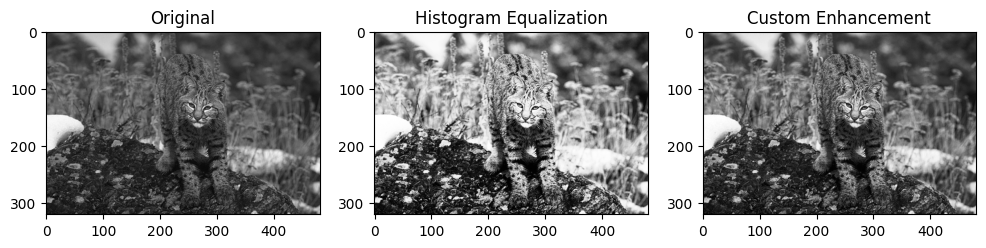

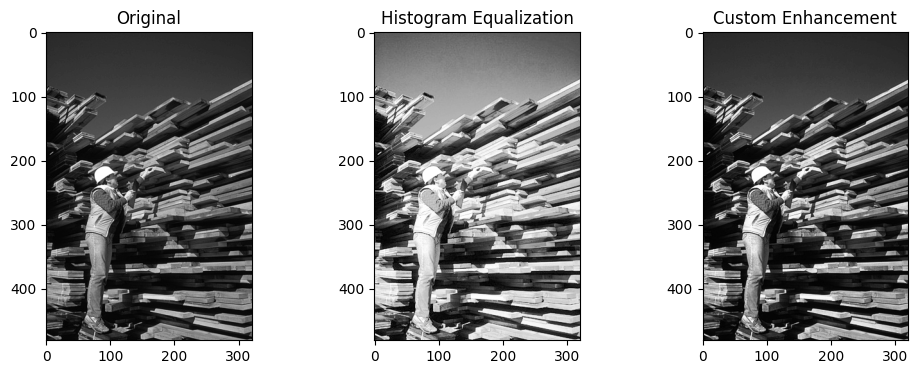

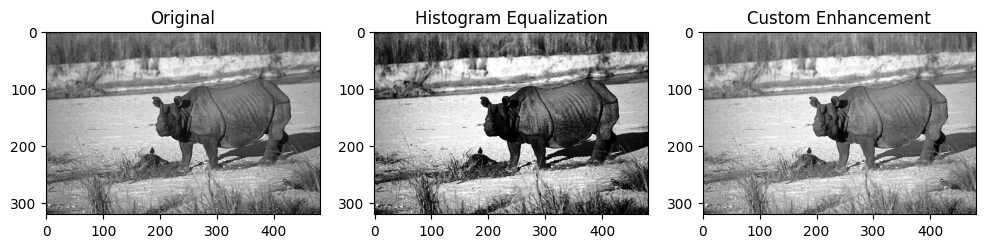

In [211]:
import random

# Randomly select a few images to display
sample_images = random.sample(images, 3)
for i, image in enumerate(sample_images):
    hist_eq_image = histogram_equalization(image)
    custom_enhanced_image = entropy_based_contrast_enhancement(image)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Histogram Equalization")
    plt.imshow(hist_eq_image, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Custom Enhancement")
    plt.imshow(custom_enhanced_image, cmap='gray')
    plt.show()


### Debug

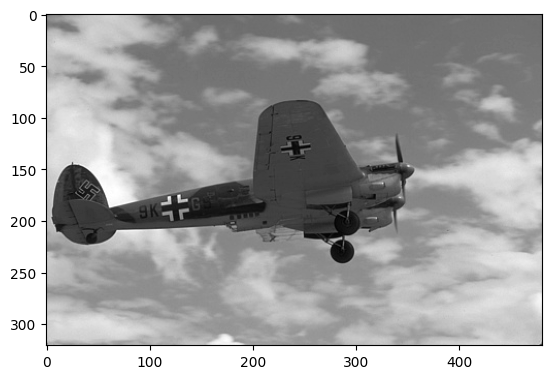

In [ ]:
plt.imshow(images[1], cmap='gray')

In [ ]:
entropy_based_contrast_enhancement(images[0])

| Paper has | 344.60574674513845 | 89.60574674513845 |
| Code has | 165.39425325486155 | 89.60574674513845 |


ValueError: fp and xp are not of the same length.